# E8. 인물사진을 만들어 보자

## 1. 인물사진 모드란?

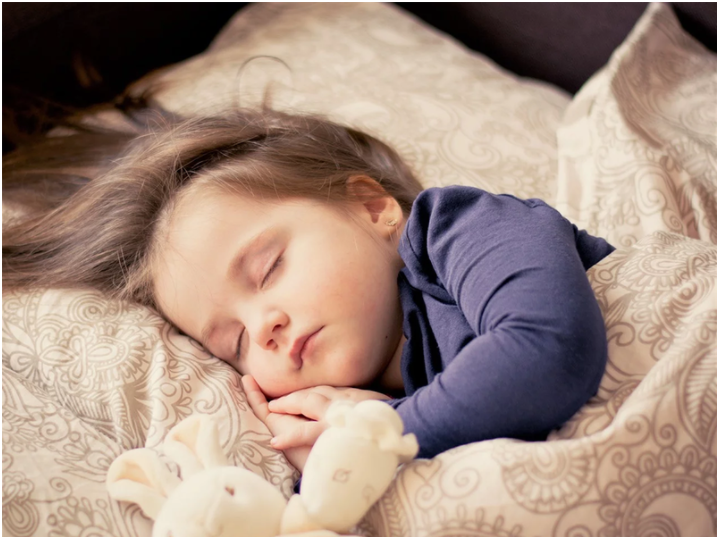
- 피사체를 가깝게 찍을 때 배경이 흐려지는 효과
- DSLR이나 미러리스 같은 전문적인 카메라와 렌즈에서 만들어 내기 쉬운 효과
- 하지만 피사체를 충분히 가까운 거리에 두고 촬영한다면 핸드폰 카메라에서도 비슷한 효과낼 수 있음
- 특히, 2개 이상의 렌즈를 탑재한 최신 휴대폰에서는 **'인물사진 모드(portrait mode)'**가 지원됨
- [iPhone에서 인물 사진 모드 사용하기](https://support.apple.com/ko-kr/HT208118)
- 핸드폰 카메라의 인물사진 모드는 듀얼 카메라를 이용해 DSLR의 아웃포커싱 기능을 흉내냄
- 물론 인물사진의 아웃포커싱 구현은 DSLR의 아웃포커싱 구현과는 다름
    - DSLR에서는 사진을 촬영할 때, [피사계 심도(depth of field, DOF)](https://ko.wikipedia.org/wiki/%ED%94%BC%EC%82%AC%EA%B3%84_%EC%8B%AC%EB%8F%84)를 얕게 하여 초점이 맞은 피사체를 제외한 배경을 흐리게 만듬
    - 핸드폰 인물사진 모드는 화각이 다른 두 렌즈를 사용. 일반(광각) 렌즈에서는 배경을 촬영하고 망원 렌즈에서는 인물을 촬영한 뒷배경을 흐리게 처리한 후 망원 렌즈의 인물과 적절하게 합성
- 이번 노드에서의 목표는 핸드폰 인물사진 모드. 핸드폰 인물 사진 모드를 정확히 따라 하기 위해서 2개의 렌즈가 필요하지만 딥러닝을 적용해서 하나의 렌즈만으로 비슷하게 구현

### 인물사진 모드에서 사용되는 용어
- 한국에서는 배경을 흐리게 하는 기술을 주로 '아웃포커싱'이라고 표현
- 하지만 아웃포커싱은 한국에서만 사용되는 용어이고 정확한 영어 표현은 **얕은 피사계 심도(shallow depth of field)** 또는 **셀로우 포커스(shallow focus)**라고 함
- 또한, "보케(bokeh)"라는 일본어에서 유래된 표현 또한 사용함
- 영문권에서도 많이 사용하는 용어지만 사실 전문적으로 사진을 다루는 사람이 아니면 그 의미가 직관적으로 다가오기 어려움
- 핸드폰 제조사에서도 이것을 알고 '인물사진(portrait)'라는 직관적인 용어 사용

### 학습목표

- 딥러닝을 적용하여 핸드폰 인물 사진 모드 따라해보기

### 준비물

- 실습을 위한 폴더 만들기
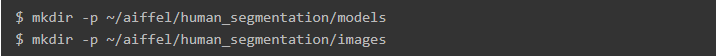

## 2. 셀로우 포커스 만들기 (1) 사진을 준비하자

### 하나의 카메라로 셀로우 포커스(shallow focus)를 만드는 방법
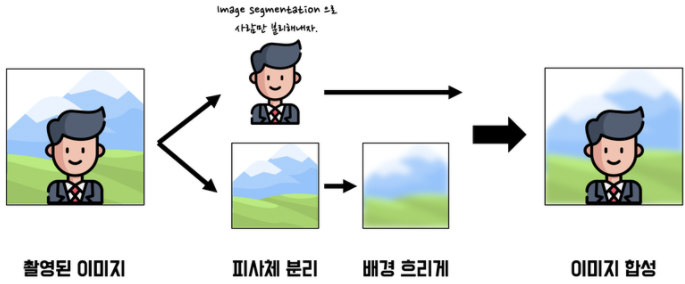
- 두 개의 렌즈가 맡은 역할을 하나의 렌즈에서 구현해야 함
- 이미지 세그멘테이션(image segmentation) 기술을 이용하면 하나의 이미지에서 배경과 사람을 분리할 수 있음
- 분리된 배경을 블러(blur) 처리 후 사람 이미지와 다시 합하면 아웃포커싱 효과를 적용한 인물 사진을 얻을 수 있음
- 다음과 같은 후가공으로 '인물사진 모드'인 사진 만들 것
    - 1. 배경이 있는 셀카를 촬영(배경과 사람의 거리가 약간 멀리 있으면 좋음)
    - 2. 시멘틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리
    - 3. 블러링(blurring) 기술로 배경을 흐리게 하기
    - 4. 피사체를 배경의 원래 위치에 합성하기

### 사진을 준비하자
- 사진을 촬영한 후 새로 생성한 폴더에 저장
- 사용할 디렉토리는 아래와 같음
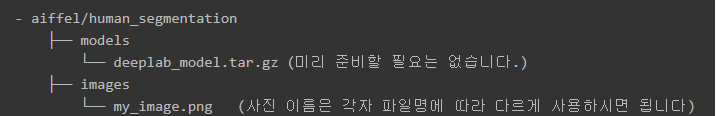

In [1]:
# 필요한 모듈 import
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [20]:
# 준비한 이미지 읽기
# 리눅스 명령어 'pwd'를 사용하면 손쉽게 파일의 절대 경로 찾을 수 있음
import os
img_path = os.getenv('HOME') + '/aiffel/human_segmentation/images/jiyoon.png'
img_orig = cv2.imread(img_path)
print(img_orig.shape)

(750, 1000, 3)


## 3. 셀로우 포커스 만들기 (2) 세그멘테이션으로 사람 분리하기

- 배경에만 렌즈 흐림 효과를 주기 위해서 그림과 같이 이미지에서 사람과 피사체를 분리해야 함
- 흔히 포토샵으로 '누끼 따기'라는 것이 바로 이런 작업을 의미
- 인물 사진에서 배경만 다르게 편집하려는 용도로 흔히 하는 작업
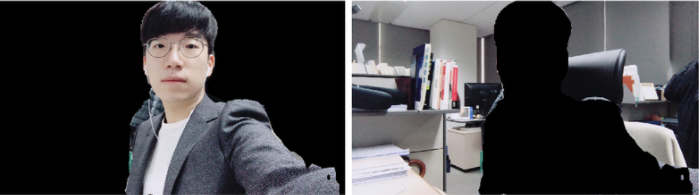

### 세그멘테이션(Segmentation)이 뭔가요?
- 이미지 세그멘테이션? 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법
- 이미지 세그멘테이션은 모든 픽셀에 라벨(label)을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정
- 이때 공통 특징은 물리적 의미가 없을 수도 있음
- 픽셀이 비슷하게 생겼다는 사실은 인식하지만, 실제 물체 단위로 인식하지 않을 수 있는 것
- 물론 세그멘테이션에는 여러 가지 세부 테스크가 있으며, 테스크에 따라 다양한 기준으로 객체를 추출

### 시멘틱 세그멘테이션(semantic segmentation)이란?
- 시멘틱 시그멘테이션? 세그멘테이션 중에서도 특히 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션
- 쉽게 설명하면 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법이라고 이해
- [MS COCO datasets의 시멘틱 세그멘테이션 라벨](https://cocodataset.org/#explore)
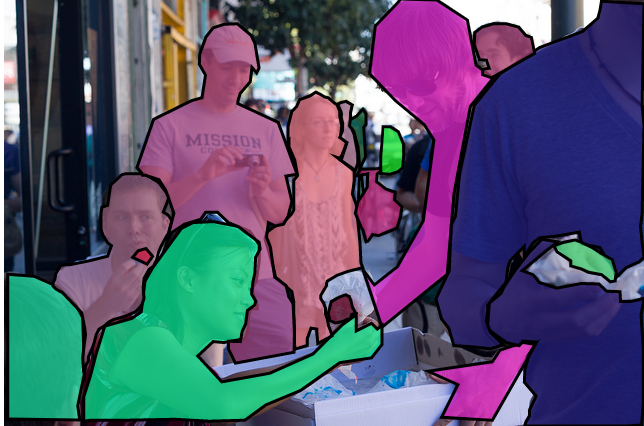

### 인스턴스 세그멘테이션(instance segmentation)이란?
- 시멘틱 세그멘테이션은 '사람'이라는 추상적인 정보를 이미지에서 추출해내는 방법
- 그래서 사람이 누구인지 관계없이 같은 라벨로 표현
- 더 나아가서 인스턴스 세그멘테이션은 사람 개개인별로 다른 라벨을 가지게 함
- 여러 사람이 한 이미지에 등장할 때 각 개체를 분할해서 인식하자는 것이 목표

### 딥러닝에 기반한 방법 이전에는 어떻게 이미지 세그멘테이션을 했을까?
#### 웨터쉐드 세그멘테이션(watershed segmentation)
> 이미지에서 영역을 분할하는 가장 간단한 방법은 물체의 '경계'를 나누는 것<br>
그럼 경계는 어떻게 나눌 수 있을까?<br>
이미지는 그레이스케일(grayscale)로 변환하면 0 ~ 255값의 가짐<br>
픽셀 값을 이용해서 각 위치의 높고 낮음을 구분<br>
낮은 부분부터 서서히 '물'을 채워 나간다고 생각하면 각 영역에서 물이 차오르다가 넘치는 시점 생기게 됨<br>
그 부분을 경계선으로 만들면 물체를 서로 구분할 수 있게 됨<br>
자세한 내용은 [opencv-python tutorial](https://opencv-python.readthedocs.io/en/latest/doc/27.imageWaterShed/imageWaterShed.html)을 참고

## 4. 셀로우 포커스 만들기 (3) 시맨틱 세그멘테이션 다뤄보기

- 본격적으로 세그멘테이션을 구현
- 세그멘테이션 문제에는 FCN, SegNet, U-Net 등 많은 모델이 사용됨
- 그중에서 DeepLab이라는 세그멘테이션 모델을 만들고 모델에 이미지를 입력
- DeepLab 알고리즘(DeepLab v3+)은 세그멘테이션 모델 중에서도 성능이 매우 좋아 최근까지도 많이 사요ㅏㅇ되고 있음
- 이번에는 네트워크에 대한 자세한 설명보다는 세그멘테이션의 활용 방법 위주로 다룰 예정
- DeepLab에 대한 자세한 설명은 여기를 참고
- [DeepLab V3+:Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation](https://blog.lunit.io/2018/07/02/deeplab-v3-encoder-decoder-with-atrous-separable-convolution-for-semantic-image-segmentation/)
- 참고자료: [Xception 더 알아보기](https://arxiv.org/abs/1610.02357)
- [DeepLab Demo](https://github.com/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb)

In [21]:
# DeepLab 모델 준비
# 구글에서 제공하는 모델 구조를 그대로 가지고 와 'DeepLabModel' 클래스 만들기
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'
    
     # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어드린 그래프구조 graph_def를
     # tf.compat.v1.import_graph_def를 통해 불러들여 활용
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()
        
        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name = '')
            
        self.sess = tf.compat.v1.Session(graph = self.graph)
        
    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환
    # 전처리 하는 함수 - input tensor를 만들기 위해 preprocess() 함수에서 이미지 전처리
    # 모델이 받는 입력 크기가 정해져 있으므로 이에 따라 적절한 크기고 resize
    # OpenCV의 디폴트 BGR 채널 순서를 텐서플로우에 맞는 RGB로 수정
    # 전처리된 이미지는 run() 함수에서 입력값으로 사용되는 것 볼 수 있음
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
    
    # 실제로 세그멘테이션을 하는 함수
    def run(self, image):
        img_input = self.preprocess(image)
        
        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_Dict = {input...})
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict = {self.INPUT_TENSOR_NAME:[img_input]})
        
        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

#### 편집자주
- AIFFEL의 딥러닝 관련 코드는 Tensorflow V2 기준으로 작성되지만, 이번 노드에서는 구글에서 Tensorflow V1으로 작성한 DeepLab 모델 구조를 그대로 가져와 활용
- Tenssorflow V2에서 V1 코드와 모델 구조를 활용할 수 있도록 제공하는 'tf.compat.v1'를 활용하고 있음
- 그래서 다소 생소할 수 있는 'session', 'graph', 'feed_dict' 등 Tensorflow V2에서는 'Model', 'Input' 등에 감추어져 있는 구조가 위 코드에 드러나 있음
- Tensorflwo V1에서 작성된 수많은 레거시 코드들을 활용하려면 어떻게 해야 하는지를 학습하는 의미에서 Tensorflow V2 코드와 키교해 가면서 보기를 권장

In [22]:
# 사전에 학습된 가중치(pretrained weight) 불러오기
# 구글에서 제공하는 파일 다운로드
# "model loaded successfully!"라는 문구가 뜰 때까지 오래 걸릴 수 있음

# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME') + '/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz', download_path)
    
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

model loaded successfully!


- 구글이 제공하는 'deeplabv3_mnv2_pascal_train_aug_2018_01_29' weight을 다운로드하고 'DeepLabModel'을 초기화
- 이 모델은 PASCAL VOC 2012'라는 대형 데이터셋으로 학습된 v3 버전
- 다양한 데이터셋과 백본(backbone) 모델에 대한 pretrained_weight는 [여기](https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/model_zoo.md)에서 확인할 수 있음
- 첫 단계에서 준비한 이미지를 네트워크에 입력

In [23]:
img_resized, seg_map = MODEL.run(img_orig)
print(img_orig.shape, img_resized.shape, seg_map.max())

(750, 1000, 3) (384, 513, 3) 15


- 'img_orig'의 크기는 '1280x960'이고 'img_resized'의 크기는 '513x384'이 출력됐음
- 입력 이미지 크기가 달라지면 resize 크기도 조금씩 달라짐
- cv2는 이미지를 HWC(Height, Width, Channel) 순서로 표시
- 세그맨테이션 맵에서 가장 큰 값(물체로 인식된 라벨 중 가장 큰 값)을 뜻하는 'seg_map.max()'는 '15'이라는 값이 출력됨(사진에 따라서 seg_map.max()' 값이 다르게 출력됨)
- 위에서 언급한 것처럼 구글이 제공한 DeepLab은 PASCAL VOC의 라벨로 학습되었음
- 제공하는 라벨 종류는 다음과 같음

In [24]:
LABEL_NAMES = [
    'background', 'aeroplnae', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

- background를 제외하면 20개의 클래스가 있음
- 따라서 '20'의 의미는 'tv'가 됨
- 0부터 시작
- 이 중 사람('person') 라벨, 즉 15를 가진 영역만 검출해 내고 싶음
- 마스크를 만들고 시각화

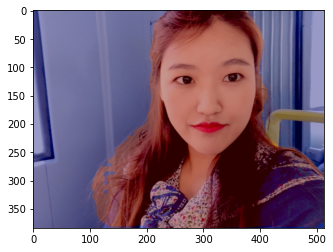

In [25]:
img_show = img_resized.copy()
# 예측 중 사람만 추출
# 사람을 뜻하는 15 외 예측은 0으로 만들었음
seg_map = np.where(seg_map == 15, 15, 0)
# 예측된 세그멘테이션 이미지(map)는 최댓값이 15가 됨
# 일반 이미지는 0부터 255까지 값을 사용해 픽셀을 표현
# 세그멘테이션 맵에 표현된 값을 원본이미지에 그림형태로 출력하기 위해 255로 정규화
# 255 normalization
img_mask = seg_map * (255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
# 'applyColorMap()' 함수로 색을 적용하고 이미지를 화면에 출력
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 5. 셀로우 포커스 만들기 (4) 세그멘테이션 결과를 원래 크기로 복원하기

- DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize해서 입력
- 따라서 출력한 resize된 입력 크기와 같게 나오게 됨
- 세그멘테이션 결과(mask)를 원래 크기로 복원

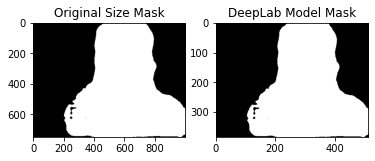

In [26]:
# 'cv2.resize()' 함수 이용
# 크기를 키울 때 보간(interpolation) 고려
# cv2.INTER_NEAREST를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 'cv2.INTER_LINEAR'를 사용
# 보간법은 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법
# 결과적으로 'img_mask_up'은 경계가 블러된 픽셀값 0 ~ 255의 이미지 얻음
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation = cv2.INTER_LINEAR)
# 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값('threshold') 설정
# 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법ㅌ
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)


ax = plt.subplot(1, 2, 1)
plt.imshow(img_mask_up, cmap = plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1, 2, 2)
plt.imshow(img_mask, cmap = plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

#### [opencv-python 문서: 이미지의 기하학적 변형](https://opencv-python.readthedocs.io/en/latest/doc/10.imageTransformation/imageTransformation.html)
- Scaling: 이미지의 사이즈가 변하는 것
- OpenCV에서는 'cv2.resize()' 함수 사용하여 적용
- 사이즈가 변하면 pixel 사이의 값을 결정해야 하는데, 이때 사용하는 것이 보간법(Interpolation method)
- 많이 사용되는 보간법은 사이즈를 줄을 때에는 'cv2.INTER_AREA', 사이즈를 크게할 때는 'cv2.INTER_CUBIC', 'cv2.INTER_LINEAR' 사용
```python
cv2.resize(img, dsize, fx, fy, interpolation)
```
- Parameters
    - img: Image
    - dsize: Manual Size. 가로, 세로 형태의 tuple(Ex:(100, 200)
    - fx: 가로 사이즈의 배수. 2배로 크게하려면 2. 반으로 줄이려면 0.5
    - fy: 세로 사이즈의 배수
    - interpolation: 보간법

## 6. 셀로우 포커스 만들기 (5) 배경 흐리게 하기

- 배경 흐리게 만들기
- 'blur()' 함수 이용

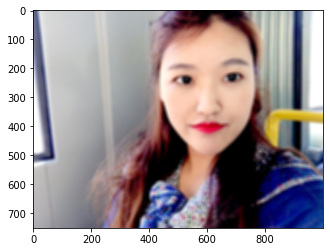

In [27]:
# (13, 13)은 blurring kernel size를 의미
img_orig_blur = cv2.blur(img_orig, (13, 13))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

- 흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

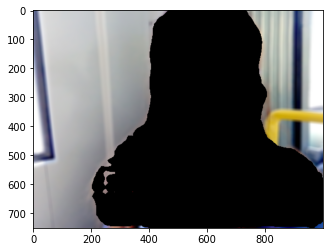

In [28]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
# bitwise_not 함수를 이용하면 이미지가 반전됨
# 배경은 255, 사람은 0이 됨
img_bg_mask = cv2.bitwise_not(img_mask_color)
# 반전된 세그멘테이션 결과를 이용해서 이미지와 'bitwise_and' 연산을 수행하면 배경이 있는 영상 얻을 수 있음
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

- [StackOverflow: bitwise_not, bitwise_and 함수를 사용해 이미지 바꾸기](https://stackoverflow.com/questions/32774956/explain-arguments-meaning-in-res-cv2-bitwise-andimg-img-mask-mask)

## 7. 셀로우 포커스 만들기 (6) 흐린 배경과 원본 영상 합성

- 배경 영상과 사람 영상을 합치기

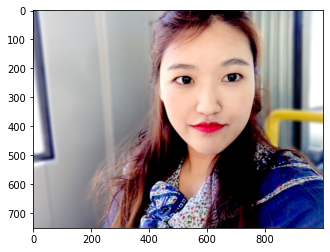

In [29]:
# 세그멘테이션 마스크가 255인 부분만 원본 영상을 가지고 오고, 반대인 영역은 블러된 미지 값을 사용
img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

#### numpy.where() 사용법
- [numpy.where()사용법](https://numpy.org/doc/stable/reference/generated/numpy.where.html)

- 인물과 배경의 거리차이가 있고 거리가 일정할 수록 더 자연스러워 보임